jupyter notebook --NotebookApp.iopub_data_rate_limit=7368709120

In [48]:
# Reset memory

%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [49]:
import warnings
warnings.filterwarnings("ignore")
import joblib
import mlflow

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import spearmanr
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer

In [51]:
import xgboost as XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
import xgboost
from xgboost import XGBClassifier
import lime
import lime.lime_tabular
from sklearn.feature_selection import SelectPercentile, f_classif


In [53]:
df = pd.read_csv('C:/Users/td/implement_scoring_loan/notebook/data_cleaned.csv')

# Imbalanced Class

In [ ]:
# summarize the class distribution
from collections import Counter

target = df.values[:,2]
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

In [ ]:
X=df.drop(['TARGET'],axis=1)
y=df['TARGET']

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# Séparation des données en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

# Équilibrage des données en utilisant SMOTE
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_train_resampled, y_train_resampled= pipeline.fit_resample(X_train, y_train)

In [ ]:
y_train_resampled.value_counts()/len(y_train_resampled)

# Features Selection

In [ ]:
# Sélection des caractéristiques les plus importantes
selector = SelectPercentile(score_func=f_classif, percentile=2)
X_train_new = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_new = selector.transform(X_test)

In [ ]:
data = X_train_resampled.iloc[0]


In [ ]:
# Obtention des scores des caractéristiques
scores = selector.scores_

# Obtention des noms des caractéristiques
feature_names = X.columns.values

# Obtention d'un tableau booléen indiquant les caractéristiques sélectionnées
mask = selector.get_support()

# Obtention des noms et des scores des caractéristiques sélectionnées
selected_feature_names = feature_names[mask]
selected_scores = scores[mask]

# Tri des noms et des scores par ordre décroissant de score
sorted_indices = np.argsort(selected_scores)
sorted_feature_names = selected_feature_names[sorted_indices]
sorted_scores = selected_scores[sorted_indices]

# Création d'un barplot trié par ordre décroissant de score
plt.figure(figsize=(10, 20))
plt.barh(sorted_feature_names, sorted_scores)
plt.xlabel('Score')
plt.ylabel('Caractéristiques')
plt.title('Importance des caractéristiques')

# Inclinaison des noms de variables à un angle de 45 degrés
plt.xticks(rotation=45)

plt.show()


# Dummy

Before we can improve our model, we need a baseline.

In [ ]:
clf_dummy = DummyClassifier(random_state=39) 
#establishing random_state for reproducibility
clf_dummy.fit(X_train_new ,y_train_resampled)
y_pred = clf_dummy.predict(X_test_new)

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred);

## MLFLOW UI

In [ ]:
cv = StratifiedKFold(n_splits=5)

In [ ]:
def log_mlflow(model):
    # Track params and metrics 
    with mlflow.start_run() as run:
        mlflow.set_tag("model_name", name)
        mlflow.log_param("Colums", paramgrid)
        # Save model to artifacts
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', models_[model_]['model'])])
        gscv = GridSearchCV(pipe, param_grid=models_[model_]['params'], cv=cv,scoring='accuracy')
        gscv.fit(X_train_resampled,y_train_resampled)
        mlflow.sklearn.log_model(gscv.best_estimator_, name)
        accuracy = round(accuracy_score(y_test, y_pred), 4)
        auc = roc_auc_score(y_test, y_pred)
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("accuracy", accuracy)
        
    mlflow.end_run()

In [ ]:
def score_metier(y_true, y_pred):
    cost_fn = 10 # Coût d'un FN est dix fois supérieur au coût d'un FP
    cost_fp = 1
    # Matrice de confusion pour calculer le nombre de FN et de FP
    confusion_matrix = np.array([[np.sum((y_pred == 0) & (y_true == 0)), np.sum((y_pred == 1) & (y_true == 0))],
                                 [np.sum((y_pred == 0) & (y_true == 1)), np.sum((y_pred == 1) & (y_true == 1))]])
    score_metier = cost_fp * confusion_matrix[0,1] + cost_fn * confusion_matrix[1,0]
    return score_metier

In [ ]:
param_log_reg = {'model__penalty': ['l1', 'l2'],
    'model__C': np.logspace(-4, 4, 20),
    'model__solver': ['liblinear', 'saga']
}

param_Xgboost = {
    'model__n_estimators': [50,100],
    'model__max_depth': [3, 4],
    'model__learning_rate': [0.01, 0.2]
}

In [ ]:
# Dictionnaire de classifieurs 
models_ = { 'Logistic Regression':{'model':LogisticRegression(),'params':param_log_reg},
            'Xgboost':{'model': XGBClassifier(), 'params':param_Xgboost}
              }

In [ ]:
# Dictionnaire de classifieurs 
models_ = { 'Logistic Regression':{'model':LogisticRegression(),'params':param_log_reg},
            'Xgboost':{'model': XGBClassifier(), 'params':param_Xgboost}
              }
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.sklearn.autolog()

for model_ in models_.keys():
    experiment_name = model_
    mlflow.set_experiment(experiment_name)
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', models_[model_]['model'])])
    gscv = GridSearchCV(pipe, param_grid=models_[model_]['params'], cv=cv,scoring='accuracy')
    gscv.fit(X_train_resampled,y_train_resampled)
    
    with mlflow.start_run(run_name=model_):
        mlflow.sklearn.log_model(gscv.best_estimator_, model_)
        
        # Evaluate the model on the test data

        probabilities = pipe.predict_proba(X_test)
        #Score metier
        threshold = 0.7
        y_pred = np.where(probabilities[:, 1] >= threshold, 1, 0)

        cost_fn = 10  # coût d’un FN est dix fois supérieur au coût d’un FP
        cost_fp = 1
        # Matrice de confusion pour calculer le nombre de FN et de FP ## Voir proba avec seuil
        confusion_matrix = np.array([[np.sum((y_pred == 0) & (y_test == 0)), np.sum((y_pred == 1) & (y_test == 0))],
                                     [np.sum((y_pred == 0) & (y_test == 1)), np.sum((y_pred == 1) & (y_test == 1))]])
        score_metier = cost_fp * confusion_matrix[0,1] + cost_fn * confusion_matrix[1,0]

        # Log the model
        mlflow.sklearn.log_model(pipe, "model")

        # score_metier as metrics
        accuracy = round(accuracy_score(y_test, y_pred), 4)
        auc = roc_auc_score(y_test, y_pred)
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("score_metier", score_metier)

mlflow.end_run()

In [ ]:
# ## Erase experiment
# from mlflow.tracking import MlflowClient

# client = MlflowClient()
# experiments = client.search_experiments("DummyClassifier")
# for experiment in experiments:
#     client.delete_experiment(experiment.experiment_id)


## STREAMLIT AND FASTAPI

In [13]:
# Features selection
selector = ColumnTransformer(
    transformers=[('select', 'passthrough', selected_feature_names)],
    remainder='drop'
)

In [14]:
# Transform Features

preprocessor=PowerTransformer(method='yeo-johnson',standardize=True)

In [15]:
# Saving the selected model

model_saved=LogisticRegression()

In [16]:
pipeline = Pipeline(steps=[
    ('feature_selection', selector), 
    ('preprocessing', preprocessor), 
    ('model', model_saved)
])

In [17]:
# Fit model

pipeline.fit(X,y)

Pipeline(steps=[('feature_selection',
                 ColumnTransformer(transformers=[('select', 'passthrough',
                                                  array(['CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE',
       'NAME_EDUCATION_TYPE_Higher education', 'BURO_DAYS_CREDIT_MIN',
       'BURO_DAYS_CREDIT_MEAN', 'BURO_DAYS_CREDIT_UPDATE_MEAN',
       'BURO_CREDIT_ACTIVE_Active_MEAN', 'BURO_CREDIT_ACTIVE_Closed_MEAN',
       'PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
       'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
       'PREV_CODE_REJECT_REASON_XAP_MEAN'], dtype=object))])),
                ('preprocessing', PowerTransformer()),
                ('model', LogisticRegression())])

In [18]:
# Saving model for fastapi

joblib.dump(pipeline, 'C:/Users/td/implement_scoring_loan/api/scoring_loan.joblib')

['C:/Users/td/implement_scoring_loan/api/scoring_loan.joblib']

## LIME : FEATURE LOCAL

In [19]:
with open('C:/Users/td/implement_scoring_loan/api/selected_feature_names.pkl', 'wb') as f:
    pickle.dump(selected_feature_names, f)
    
with open('C:/Users/td/implement_scoring_loan/api/X_train_new.pkl', 'wb') as f:
    pickle.dump(X_train_new, f)

In [20]:
data=X_train_resampled[selected_feature_names].values
data.shape

(67830, 16)

In [47]:
exp.predict_proba.tolist()

[0.6227940245226543, 0.3772059754773457]

In [37]:
df[df['SK_ID_CURR'] == 100002].index[0]

0

In [21]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=data,
                                                   feature_names=selected_feature_names,
                                                   class_names=['0','1'],
                                                   discretize_continuous=True)

In [22]:
# Lime : local feature experience

# Saving model for fastapi

import dill

with open('C:/Users/td/implement_scoring_loan/api/explainer.pkl', 'wb') as f:
    dill.dump(explainer, f)

In [41]:
instance = X[selected_feature_names].values[0]

In [24]:
exp = explainer.explain_instance(instance,pipeline
                                 .set_params(feature_selection=None)
                                 .predict_proba, num_features=16)
# Récupérer les caractéristiques sélectionnées pour l'explicat


In [29]:
feature_importances = exp.as_map()

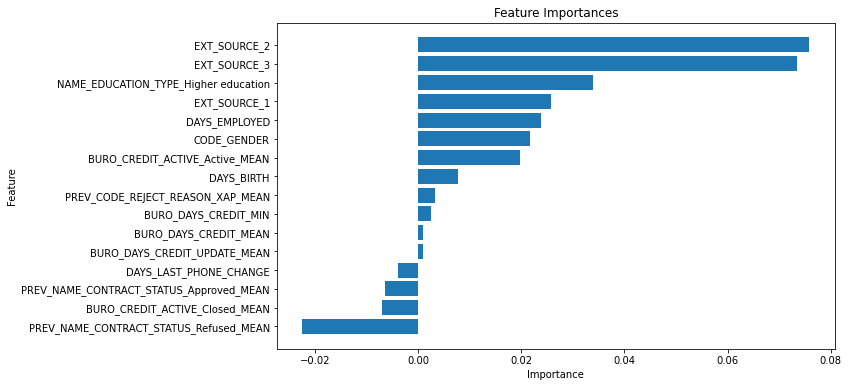

In [30]:

importances = [t[1] for t in feature_importances[1]]
feature_names = [t[0] for t in feature_importances[1]]
selected_indices = [t[0] for t in feature_importances[1]]
feature_names = [selected_feature_names[i] for i in selected_indices]
df_features_importance =  pd.DataFrame(list(zip(feature_names, importances)), columns=['Features', 'Importance'])
df_features_importance = df_features_importance.sort_values(by=['Importance'],ascending=True)
# Créer un plot bar
plt.figure(figsize=(10, 6))
plt.barh(range(len(df_features_importance)), df_features_importance['Importance'], align='center')
plt.yticks(range(len(df_features_importance)), df_features_importance['Features'])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

### Unit Test


In [ ]:
# from my_module import score_metier
import unittest
class TestScoreMetier(unittest.TestCase):

    def test_score_metier(self):
        y_test = np.array([0, 1, 0, 1, 0, 1])
        y_pred = np.array([0, 1, 1, 1, 0, 0])
        expected_score = 20 # Calculé manuellement pour les entrées ci-dessus
        self.assertEqual(score_metier(y_test, y_pred), expected_score)

In [29]:
df.to_csv('C:/Users/td/implement_scoring_loan/notebook/data.csv', index=False)

In [ ]:
model_saved.